In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
os.environ['PYTHONPATH'] = ':'.join(sys.path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnnotationBbox, OffsetImage, AuxTransformBox
from matplotlib.font_manager import FontProperties

In [3]:
import hgpflow_v2.performance # don't know why this is needed, but it is
from hgpflow_v2.performance.performance import PerformanceCOCOA

from hgpflow_v2.performance.style_sheet import LABELS, COLORS, HISTTYPES, ALPHAS, LINE_STYLES, LABEL_LEN, FIG_W, FIG_H_1ROW, FIG_DPI

In [124]:
IND_THRESHOLD = 0.50

save_dir = '...'
SAVE_FIG = True

In [118]:
def plot_ed(truth_pt_eta_phi_class, pflow_pt_eta_phi_class, jet_collections={}, ev=None, log_pt=True, zoom=False, jet_radius=0.4, N_jets=2, add_legend=True):

    truth_pt, truth_eta, truth_phi, truth_class = truth_pt_eta_phi_class
    pflow_pt, pflow_eta, pflow_phi, pflow_class = pflow_pt_eta_phi_class

    fig, ax = plt.subplots(1, 1, figsize=(FIG_W/2.5, FIG_W/2.5), dpi=FIG_DPI)

    n_events = len(truth_pt)
    ev_idx = np.random.uniform(0, n_events, 1).astype(int) if ev is None else ev

    size_truth = np.array(truth_pt[ev_idx])
    size_pflow = np.array(pflow_pt[ev_idx])

    if log_pt:
        size_truth = np.log(size_truth + 1)
        size_pflow = np.log(size_pflow + 1)

    size_max = max(size_truth.max(), size_pflow.max())

    size_truth = size_truth / size_max * 300
    size_pflow = size_pflow / size_max * 300

    colors_truth = []; colors_pflow = []
    color_map = {k: v for k, v in COLORS.items() if type(k) == int}
    class_map = {k: v for k, v in LABELS.items() if type(k) == int}
    for j in truth_class[ev_idx]:
        colors_truth.append(color_map.get(j, 'black'))
    for j in pflow_class[ev_idx]:
        colors_pflow.append(color_map.get(j, 'black'))

    ax.scatter(truth_eta[ev_idx], truth_phi[ev_idx], s=size_truth, c=colors_truth, alpha=0.3)
    ax.scatter(pflow_eta[ev_idx], pflow_phi[ev_idx], s=size_pflow, c=colors_pflow, alpha=0.3, marker='x')

    ax.scatter([], [], c='black' , label=LABELS['truth'], alpha=0.3)
    ax.scatter([], [], c='black' , label=LABELS['hgpflow'], alpha=0.3, marker='x')
    ### draw legend for color map
    for c, col in color_map.items():
        if c==5:
            continue
        ax.scatter([], [], c=col, label=class_map[c], alpha=0.3)

    xmin, xmax = -3, 3
    ymin, ymax = -np.pi, np.pi

    phase = 0
    jet_legend_handles = []
    for col_name, jet_col in jet_collections.items():
        # draw a circle for each leading two jets
        jets = jet_col[ev]
        col = COLORS[col_name]
        for i, j in enumerate(jets):
            circle = plt.Circle((j.eta, j.phi_std), jet_radius, color=col, fill=False, linestyle='--' if col_name == 'truth' else '-', alpha=0.5)
            ax.add_artist(circle)
            text_r = 1.55 if col_name == 'truth' else 2.75
            if zoom:
                text_r = 0.85 if col_name == 'truth' else 0.7
            text_x = j.eta + text_r*jet_radius * np.sin(phase)
            text_y = j.phi_std + text_r*jet_radius * np.cos(phase)            
            bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor=(0.9, 0.9, 0.9), alpha=0.8)
            ax.text(text_x, text_y, f"{round(j.pt, 1)} GeV",
                    fontsize=12, ha='center', va='center', color=col, bbox=bbox_props)

            if zoom:
                xmin = j.eta - 1.05*jet_radius
                xmax = j.eta + 1.05*jet_radius
                ymin = j.phi - 1.05*jet_radius
                ymax = j.phi + 1.05*jet_radius

            if i == N_jets - 1:
                break

        # jet_legend_handles.append(circle)
        jet_legend_handles.append(Line2D([0], [0], marker='o', color='w', linestyle='--' if col_name == 'truth' else '-', alpha=0.5))
        phase += 2*np.pi/len(jet_collections)

    # ax.set_title(f"Event {ev_idx:.0f}")

    ax.set_xlabel(f"$\eta$", fontsize=14)
    ax.set_ylabel(f"$\phi$", fontsize=14)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal', adjustable='box')

    if add_legend:

        # First legend for color map
        legend1 = ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1), ncol=1, fancybox=False, shadow=False, frameon=False, fontsize=12, handletextpad=0.1)
        
        # Second legend for jet collections
        jet_collections_keys = ['        '+x for x in list(jet_collections.keys())]
        legend2 = ax.legend(jet_legend_handles, jet_collections_keys, 
            loc='upper right', bbox_to_anchor=(1.34, 0.4), ncol=1, fancybox=False, shadow=False, frameon=False, fontsize=12, handletextpad=0.1)
        
        font_props = FontProperties(weight='book', size=14, style='oblique') #, underline=True)
        legend1.set_title("Particles", prop=font_props)
        legend2.set_title("Jets", prop=font_props)

        for jci, col_name in enumerate(jet_collections.keys()):
            del_y = jci * 0.066
            radius = 0.12
            if zoom:
                radius = radius * (xmax - xmin) / 6
            circle = Circle((0, 0), radius, color=COLORS[col_name], fill=False, linestyle='--' if col_name == 'truth' else '-', alpha=0.5)
            box = AuxTransformBox(ax.transData)
            box.add_artist(circle)
            ab = AnnotationBbox(box, (1.07, 0.26 - del_y), xycoords='axes fraction', frameon=False)
            ax.add_artist(ab)

        # Add the first legend back
        ax.add_artist(legend1)

    return fig

# Dijet

In [119]:
truth_path = 'path to test_truth.root'
mlpf_path = 'path to MLPF prediction.root'
pred_path = 'path to HGPflow prediction.root'
perf_obj_mini = PerformanceCOCOA(truth_path, pred_path, ind_threshold=IND_THRESHOLD, topo=False, pred_path_mlpf=mlpf_path)

perf_obj_mini.compute_jets(n_procs=30)

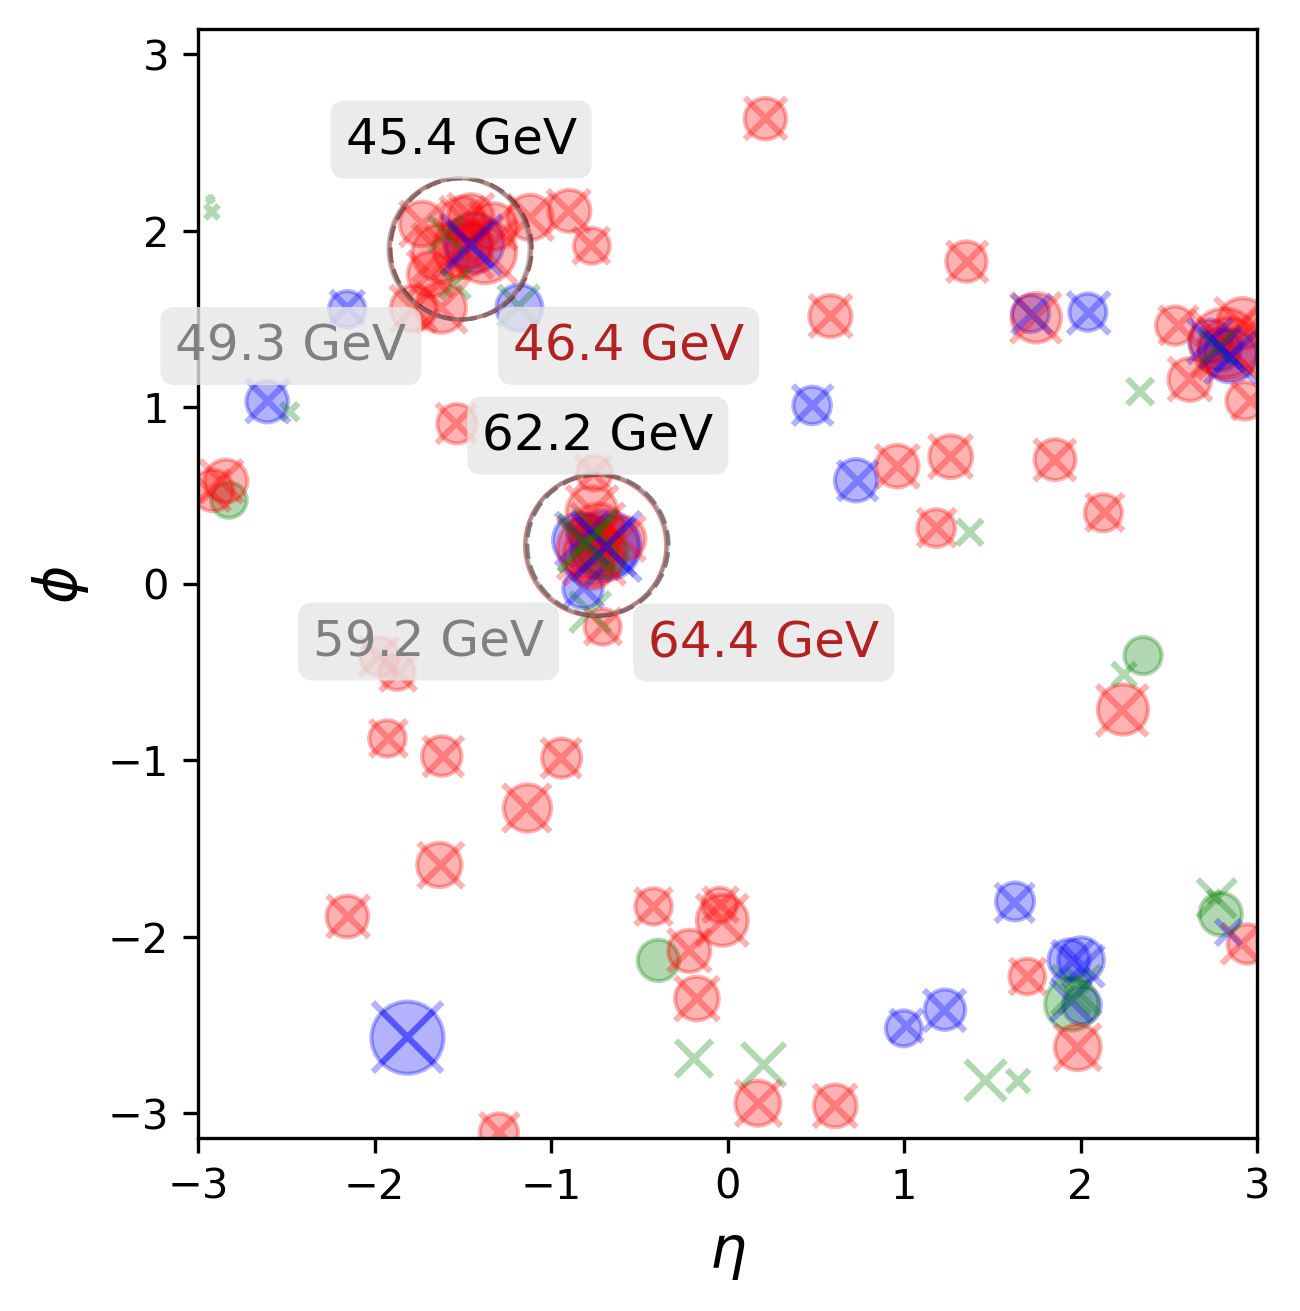

In [125]:
jet_collections = {
    'truth': perf_obj_mini.truth_dict['truth_jets'],
    'hgpflow': perf_obj_mini.hgpflow_dict['jets'],
    'ppflow': perf_obj_mini.truth_dict['ppflow_jets'],
}

event_list = [3] #list(range(10))
jet_radius = 0.4

for ev in event_list:
    plot_ed(
        (perf_obj_mini.truth_dict['particle_pt'], perf_obj_mini.truth_dict['particle_eta'], perf_obj_mini.truth_dict['particle_phi'], perf_obj_mini.truth_dict['particle_class']),
        (perf_obj_mini.hgpflow_dict['hgpflow_pt'], perf_obj_mini.hgpflow_dict['hgpflow_eta'], perf_obj_mini.hgpflow_dict['hgpflow_phi'], perf_obj_mini.hgpflow_dict['hgpflow_class']),
        jet_collections,
        ev=ev,
        jet_radius=jet_radius,
        N_jets=2 if jet_radius == 0.4 else 1,
        zoom=True if jet_radius == 1.0 else False,
        add_legend=False
    )
if SAVE_FIG:
    plt.savefig(os.path.join(save_dir, f'dijet_event_display_v2.png'), bbox_inches='tight')

# $t\bar{t}$

In [ ]:
truth_path = 'path to ttbar.root'
pred_path = 'path to HGPflow prediction.root'
mlpf_path = 'path to MLPF prediction.root'
perf_obj_ttbar = PerformanceCOCOA(truth_path, pred_path, ind_threshold=IND_THRESHOLD, topo=False, pred_path_mlpf=mlpf_path)

perf_obj_ttbar.compute_jets(n_procs=30)

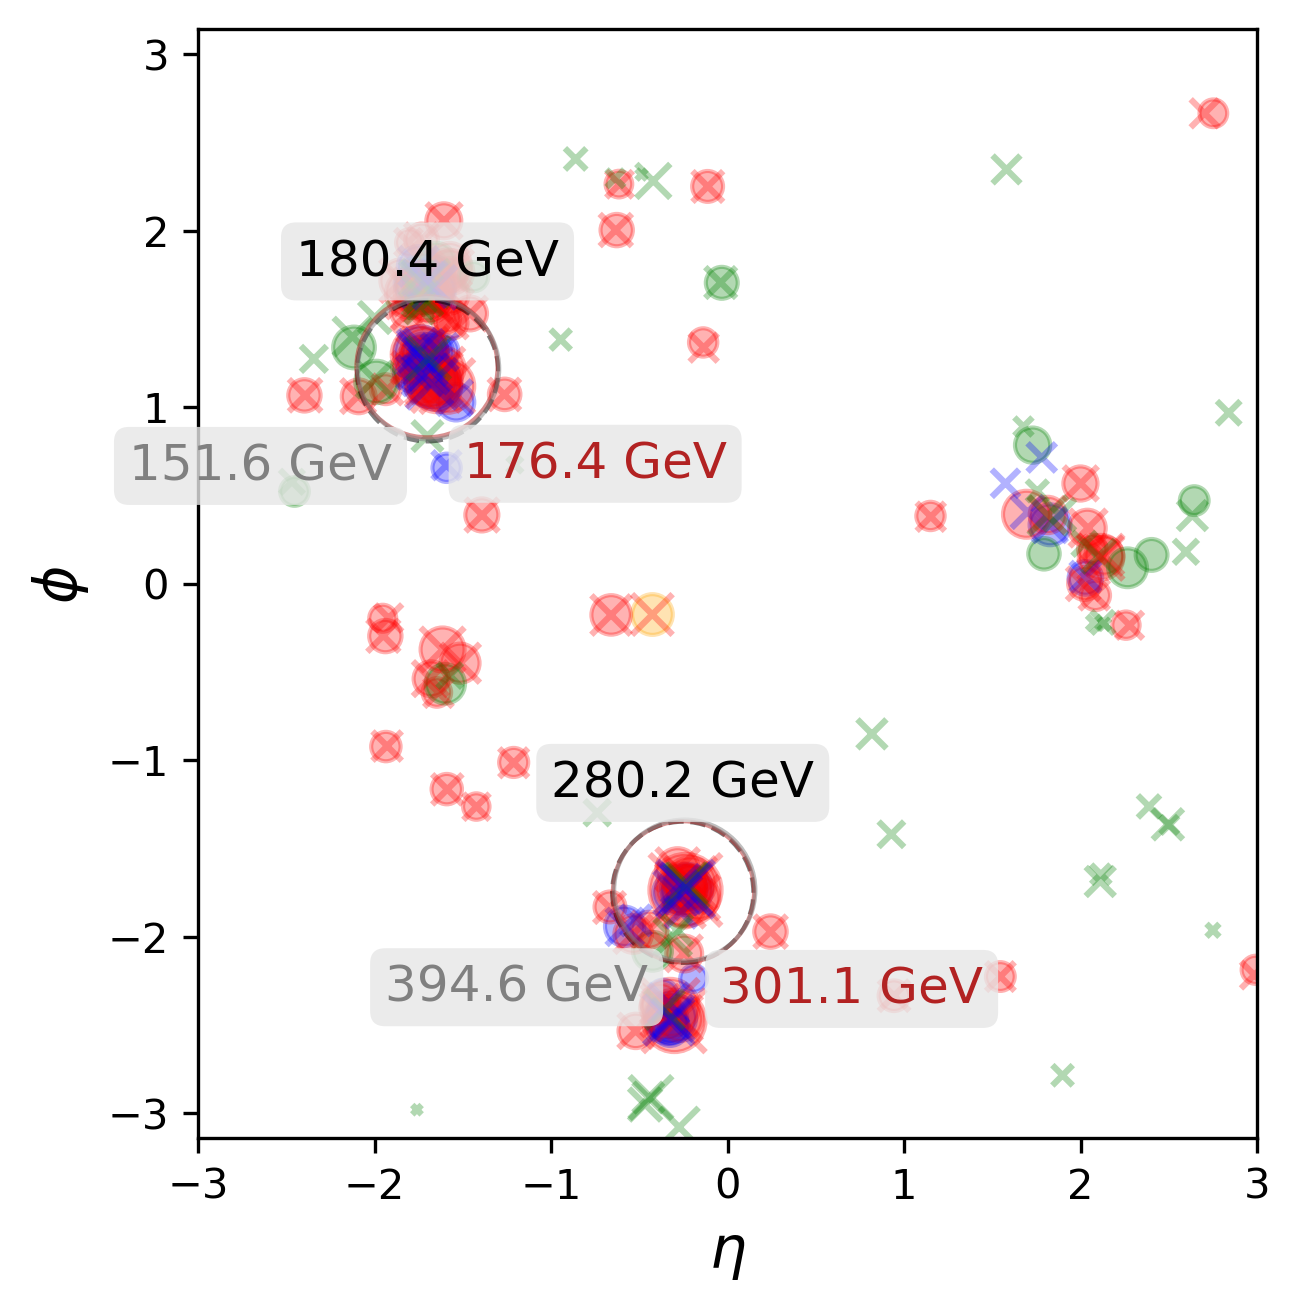

In [126]:
jet_collections = {
    'truth': perf_obj_ttbar.truth_dict['truth_jets'],
    'hgpflow': perf_obj_ttbar.hgpflow_dict['jets'],
    'ppflow': perf_obj_ttbar.truth_dict['ppflow_jets'],
}

event_list = [9] # list(range(10))
jet_radius = 0.4

for ev in event_list:
    plot_ed(
        (perf_obj_ttbar.truth_dict['particle_pt'], perf_obj_ttbar.truth_dict['particle_eta'], perf_obj_ttbar.truth_dict['particle_phi'], perf_obj_ttbar.truth_dict['particle_class']),
        (perf_obj_ttbar.hgpflow_dict['hgpflow_pt'], perf_obj_ttbar.hgpflow_dict['hgpflow_eta'], perf_obj_ttbar.hgpflow_dict['hgpflow_phi'], perf_obj_ttbar.hgpflow_dict['hgpflow_class']),
        jet_collections,
        ev=ev,
        jet_radius=jet_radius,
        N_jets=2 if jet_radius == 0.4 else 1,
        zoom=True if jet_radius == 1.0 else False,
        add_legend=False
    )

if SAVE_FIG:
    plt.savefig(os.path.join(save_dir, f'ttbar_event_display_v2.png'), bbox_inches='tight')

# $Z \left( \nu \bar{\nu}\right) H \left( b \bar{b}\right)$ - boosted

In [122]:
truth_path = 'path to zhbb boosted.root'
pred_path = 'path to HGPflow prediction.root'
mlpf_path = 'path to MLPF prediction.root'
perf_obj_zhbb_boosted = PerformanceCOCOA(truth_path, pred_path, ind_threshold=IND_THRESHOLD, topo=False, pred_path_mlpf=mlpf_path)

perf_obj_zhbb_boosted.compute_jets(n_procs=30)

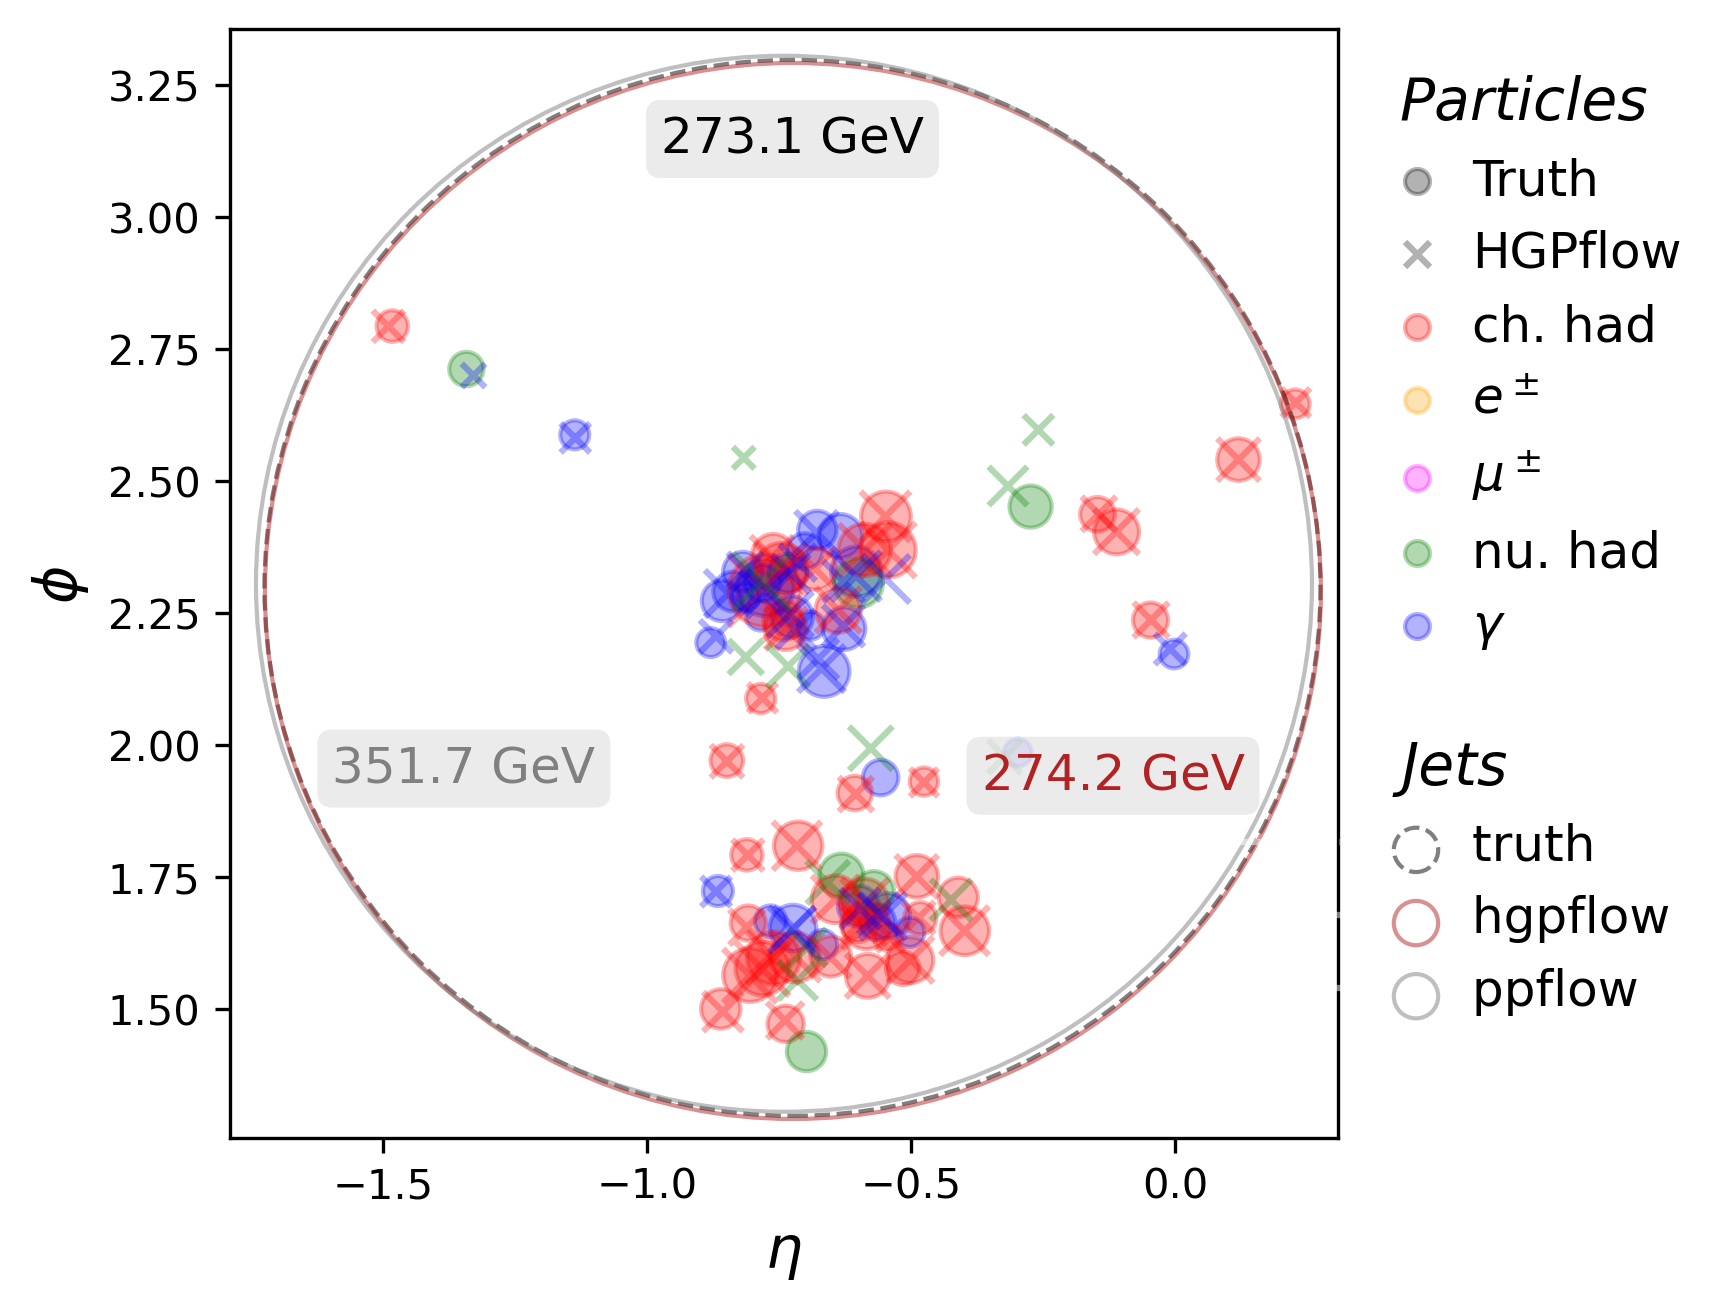

In [127]:
jet_collections = {
    'truth': perf_obj_zhbb_boosted.truth_dict['truth_jets'],
    'hgpflow': perf_obj_zhbb_boosted.hgpflow_dict['jets'],
    'ppflow': perf_obj_zhbb_boosted.truth_dict['ppflow_jets'],
}

event_list = [94] # [24, 25, 30, 32, 94]
jet_radius = 1.0

for ev in event_list:
    plot_ed(
        (perf_obj_zhbb_boosted.truth_dict['particle_pt'], perf_obj_zhbb_boosted.truth_dict['particle_eta'], perf_obj_zhbb_boosted.truth_dict['particle_phi'], perf_obj_zhbb_boosted.truth_dict['particle_class']),
        (perf_obj_zhbb_boosted.hgpflow_dict['hgpflow_pt'], perf_obj_zhbb_boosted.hgpflow_dict['hgpflow_eta'], perf_obj_zhbb_boosted.hgpflow_dict['hgpflow_phi'], perf_obj_zhbb_boosted.hgpflow_dict['hgpflow_class']),
        jet_collections,
        ev=ev,
        jet_radius=jet_radius,
        N_jets=2 if jet_radius == 0.4 else 1,
        zoom=True if jet_radius == 1.0 else False,
        add_legend=True
    )

if SAVE_FIG:
    plt.savefig(os.path.join(save_dir, f'zhbb_boosted_event_display_v2.png'), bbox_inches='tight')